In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize


In [2]:
# ----------------------------------------
# 1. 数据加载与预处理
# ----------------------------------------
prices = pd.read_excel('基金数据.xlsx', index_col='日期', parse_dates=True, skiprows=1)

# 按日期排序并填充缺失值
prices = prices.sort_index().ffill().dropna()

# 计算对数收益率
# returns = np.log(prices / prices.shift(1)).dropna()

# 投资组合初始权重与本金
w_initial = np.array([30, 40, 30])  # 纳斯达克ETF、红利低波ETF、黄金ETF,单位为万元
capital = 1_000_000
prices

,纳斯达克ETF,红利低波ETF,黄金ETF
日期,,,
2020-11-05,1.013,0.660,3.965
2020-11-06,1.005,0.663,4.001
2020-11-09,1.030,0.673,3.990
2020-11-10,0.995,0.673,3.889
2020-11-11,0.983,0.677,3.881
...,...,...,...
2025-04-14,1.797,1.095,7.327
2025-04-15,1.773,1.106,7.325
2025-04-16,1.730,1.116,7.503


In [3]:
# ----------------------------------------
# 2. 历史模拟法 VaR    使用过去500个样本数据
# ----------------------------------------
def historical_var(data, w_initial=w_initial,alpha=0.99, window=500, pre_date='2023-12-29'):
    """
    传统历史模拟法 VaR:
    - data: pd.DataFrame or 2D array of各类资产的收盘价数据
    - alpha: 置信水平
    - window: 样本容量
    返回 1 日 VaR
    """
    scenarios = data.iloc[-window:, :].copy() # 初始化样本场景
    portfolio_values = scenarios.iloc[:, 0].copy() # 初始化组合价值
    idx = data.index.get_loc(pre_date) # 找到 2023 年 12 月 29 日的行号
    w = w_initial * data.iloc[idx,:]/data.loc['2023-12-29', :] # 计算初始权重
    for i in range(len(scenarios)):
        # Vn*Vi/(Vi-1)
        scenarios.iloc[i,:] = data.loc[pre_date,:]*(data.iloc[idx-window+i+1,:]/data.iloc[idx-window+i,:]) # 计算场景下各类资产的收盘价
        portfolio_values.iloc[i] = (scenarios.iloc[i,:]/data.loc[pre_date,:]).dot(w) # 计算组合价值
        # print((scenarios.iloc[i,:]/data.loc['2023-12-29',:]).dot(w_initial))
    
    # print("样本场景:\n", scenarios.iloc[:5, :])
    # print("组合价值:\n", portfolio_values.iloc[:5])
    # 计算收益的损失分布
    losses = w.sum()-portfolio_values
    # VaR 为损失的第 alpha 分位
    pos = window*(1-alpha)
    var = losses.sort_values(ascending=False).iloc[int(pos-1)]
    return var

# 99% VaR
var_his = historical_var(prices, alpha=0.99, window=500)
print(f"传统历史模拟法 VaR (99%): {var_his:.4}万元")

传统历史模拟法 VaR (99%): 2.064万元


In [4]:
# ----------------------------------------
# 3. 时间加权历史模拟法 (λ=0.99)
# ----------------------------------------
def time_weighted_historical_var(data,  w_initial=w_initial, alpha=0.99, window=500, lambd=0.99, pre_date='2023-12-29'):
    """
    时间加权历史模拟法
    - 使用指数衰减权重 (λ^((window-1)-i))
    """
    scenarios = data.iloc[-window:, :].copy()
    portfolio_values = pd.Series(index=scenarios.index, dtype=float)
    idx = data.index.get_loc(pre_date)
    
    w = w_initial * data.iloc[idx,:]/data.loc['2023-12-29', :] # 计算初始权重

    # 生成时间衰减权重
    weights = np.array([lambd**((window-1)-i) for i in range(window)])
    weights /= weights.sum()  # 归一化
    
    # 生成场景, 与历史模拟法相同
    for i in range(len(scenarios)):
        scenarios.iloc[i,:] = data.loc[pre_date,:] * (data.iloc[idx-window+i+1,:]/data.iloc[idx-window+i,:])
        portfolio_values.iloc[i] = (scenarios.iloc[i,:]/data.loc[pre_date,:]).dot(w)
    
    losses = w.sum() - portfolio_values
    
    # 加权分位数计算
    sorted_losses = losses.sort_values(ascending=False)
    cum_weights = np.cumsum(weights[np.argsort(-losses)])
    # 找到第一个超过所需置信水平的分位数
    var = sorted_losses[cum_weights >= (1-alpha)].iloc[0]
    
    return var


# 计算结果
var_time = time_weighted_historical_var(prices, lambd=0.99)

print(f"时间加权历史模拟法 VaR (λ=0.99): {var_time:.4}万元")

时间加权历史模拟法 VaR (λ=0.99): 1.355万元


In [5]:
# ----------------------------------------
# 4. 波动率加权历史模拟法 (EWMA, λ=0.95)
# ----------------------------------------
def vol_weighted_historical_var(data, w_initial=w_initial,alpha=0.99, window=500, lambd=0.95, pre_date='2023-12-29', predic_date='2024-01-02'):
    """
    波动率加权历史模拟法
    - 使用EWMA估计波动率
    """
    # 计算收益率
    returns = data.pct_change().dropna()
    
    # EWMA波动率计算, \sigma_t = \lambda \sigma_{t-1} + (1-\lambda)r_t^2
    vol = pd.DataFrame(index=data.index, columns=data.columns)
    for j,col in enumerate(data.columns):
        ewma_var = np.zeros(len(returns))
        ewma_var[0] = returns[col].var() # 初始值为整个收益率的方差, 也可以改成第一个收益率的平方

        # 递归计算EWMA方差
        for t in range(1, len(returns)):
            ewma_var[t] = lambd * ewma_var[t-1] + (1-lambd) * returns[col].iloc[t-1]**2
            
        # 计算波动率
        vol.iloc[1:, j] = np.sqrt(ewma_var)

        # vol[col] = returns[col].ewm(alpha=1-lambd, adjust=False).std() # 直接使用pandas自带的EWMA计算方法，这个原理没懂，所以没用
    # print(returns.std())
    # print(vol.iloc[:5, :])
    
    # 获取最新波动率, 由于1月1号未开盘，使用1月2号波动率为最新波动率
    latest_vol = vol.loc[predic_date]
    
    # 生成调整后的场景
    adjusted_scenarios = pd.DataFrame(index=data.index[-window:], columns=data.columns)
    idx = data.index.get_loc(pre_date)
    w = w_initial * data.iloc[idx,:]/data.loc['2023-12-29', :] # 计算初始权重
    
    # v_i = v_n *(1 + \frac{v_i - v_{i-1}}{v_{i=1}} \cdot \frac{\sigma_n}{\sigma_i})
    for i in range(window):
        # 波动率调整因子
        vol_ratio = latest_vol / vol.iloc[idx-window+i]
        adjusted_returns = (data.iloc[idx-window+i+1,:]/data.iloc[idx-window+i,:]-1) * vol_ratio
        
        # 构建调整后价格路径
        adjusted_scenarios.iloc[i,:] = data.loc[pre_date,:] * (1 + adjusted_returns)
    
    # 计算组合价值
    portfolio_values = (adjusted_scenarios / data.loc[pre_date,:]).dot(w)
    
    # 计算VaR
    losses = w.sum() - portfolio_values
    # var = np.percentile(losses, alpha * 100)
    pos = window*(1-alpha)
    var = losses.sort_values(ascending=False).iloc[int(pos)-1]
    return var
var_vol = vol_weighted_historical_var(prices, lambd=0.95)

print(f"波动率加权历史模拟法 VaR (λ=0.95): {var_vol:.4}万元")

波动率加权历史模拟法 VaR (λ=0.95): 1.14万元


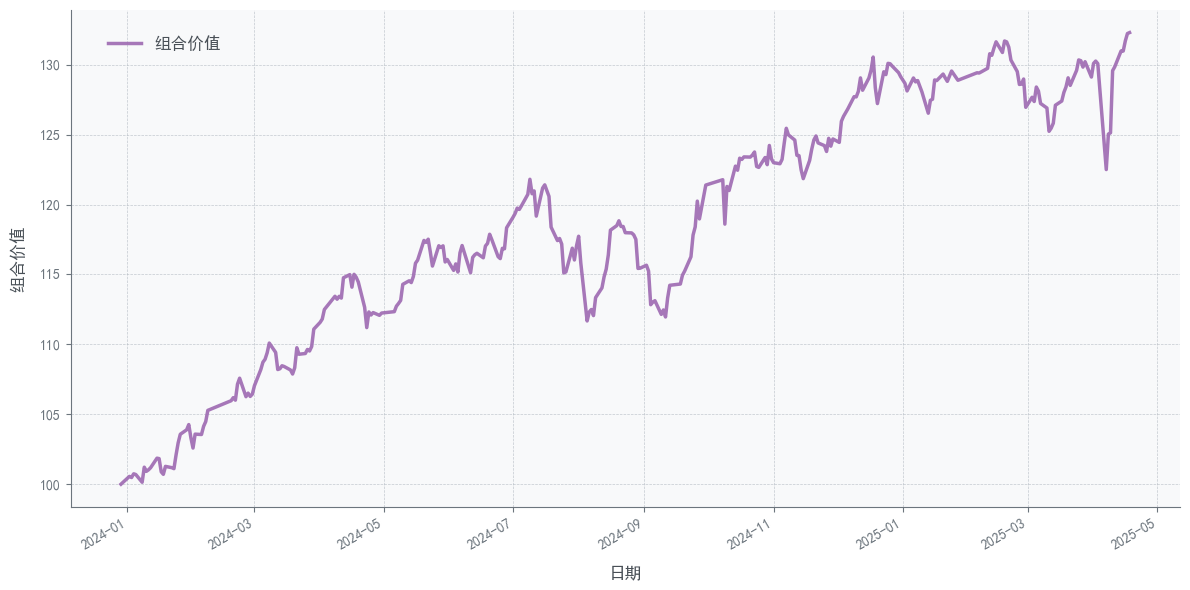

日期
2023-12-29    100.000000
2024-01-02    100.557765
2024-01-03    100.478361
2024-01-04    100.742959
2024-01-05    100.691466
                 ...    
2025-04-14    130.985593
2025-04-15    130.976314
2025-04-16    131.706826
2025-04-17    132.230391
2025-04-18    132.298697
Name: Values, Length: 313, dtype: float64

In [ ]:
# ----------------------------------------
# 5. 投资组合价值演变
# ----------------------------------------
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 从 2024-01-01 至 2025-04-18 的每日市值
start_date = '2023-12-29'
end_date = '2025-04-18'

# 2023 年 12 月 29 日的价格为基准价格
basevalue = prices.loc['2023-12-29', :]

# 筛选日期区间
slice_prices = prices.loc[start_date:end_date]
# 组合市值序列
portfolio_value = (slice_prices/basevalue).dot(w_initial)

# 绘制组合价值曲线
fig, ax = plt.subplots(figsize=(10, 6))
portfolio_value.plot(ax=ax, c='#74B9FF')
# ax.set_title('组合价值曲线')
ax.set_xlabel('日期')
ax.set_ylabel('组合价值')
# plt.tight_layout()
plt.legend(['组合价值'], loc='upper left')
plt.savefig('output/组合价值曲线.svg')
plt.show()
portfolio_value.name = 'Values'
portfolio_value.to_excel('output/固定权重组合价值.xlsx')
portfolio_value

In [10]:
# ----------------------------------------
# 6. Kupiec 检验 (比例检验)
# ----------------------------------------

def get_rolling_VaR(data, alpha=0.99, window=500):
    target_date = data.loc[start_date:end_date].index.tolist()
    VaR = np.zeros((len(target_date)-1, 3)) # [历史模拟法，时间加权历史模拟法， 波动率加权历史模拟法]
    for i in range(len(target_date)-1):
        VaR[i, 0] = historical_var(data, alpha=alpha, window=window, pre_date=target_date[i])
        VaR[i, 1] = time_weighted_historical_var(data, alpha=alpha, window=window, lambd=0.99, pre_date=target_date[i])
        VaR[i, 2] = vol_weighted_historical_var(data, alpha=alpha, window=window, lambd=0.95, pre_date=target_date[i], predic_date=target_date[i+1])
    return VaR
        

# 针对历史模拟法得到的VaR进行 Kupiec 检验
VaR = get_rolling_VaR(prices)
# pd.DataFrame(VaR, columns=['Traditional VaR', 'Time-weighted VaR', 'Vol-weighted VaR'], index=prices.loc['2024-01-02':'2025-04-19'].index[:]).to_excel('output/VaR.xlsx')

VaR

array([[2.06410399, 1.35537917, 1.14015115],
       [2.07886547, 1.34023317, 1.16747332],
       [2.05956667, 1.33279818, 1.21666547],
       [2.05712105, 1.3330904 , 1.25065295],
       [2.04946192, 1.32622075, 1.22350141],
       [2.04491082, 1.32618392, 1.23852001],
       [2.08566792, 1.3520805 , 1.33411174],
       [2.08455777, 1.34942042, 1.309605  ],
       [2.09555865, 1.35341581, 1.33351744],
       [2.09879426, 1.35339652, 1.31113483],
       [2.11367379, 1.36320857, 1.31784284],
       [2.10129587, 1.36063519, 1.31279228],
       [2.08955254, 1.34924946, 1.34933745],
       [2.08924786, 1.34894231, 1.3332303 ],
       [2.09652645, 1.35831923, 1.3826931 ],
       [2.08717374, 1.31847455, 1.68894681],
       [2.08711351, 1.31843216, 1.67442832],
       [2.11813712, 1.33443829, 1.83111679],
       [2.1512179 , 1.31056173, 2.00121473],
       [2.16278596, 1.30402665, 2.03684685],
       [2.17496916, 1.30771246, 1.99828681],
       [2.17913738, 1.31157639, 2.00178373],
       [2.

In [12]:
def kupiec_test(ret_series, var_series, alpha=0.99):
    """
    Kupiec 失败率检验:
    - ret_series: pd.Series 组合价值
    - var_series: 对应日期的 VaR 值
    - alpha: 置信水平
    返回 LR 统计量与 p 值
    """
    # 异常次数
    exceptions = ( ret_series > var_series ).astype(int)
    print(f"异常次数：{exceptions.sum()}")
    n = len(exceptions)
    m = exceptions.sum()
    # 估计失败概率
    p_hat = m / n
    p = 1 - alpha
    # 似然比统计量
    L0 = (1 - p)**(n-m) * p**m
    L1 = (1 - p_hat)**(n-m) * p_hat**m
    LR = -2 * np.log(L0 / L1)
    # p 值为卡方分布
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(LR, df=1)
    return LR, p_value

Loss = portfolio_value[:-1].values - portfolio_value[1:].values
LR, p_val = kupiec_test(Loss, VaR[:,0])
print(f"Kupiec LR={LR:.4f}, p-value={p_val:.4f}")
# 针对时间加权的历史模拟法得到的VaR进行 Kupiec 检验
LR, p_val = kupiec_test(Loss, VaR[:,1])
print(f"Kupiec LR={LR:.4f}, p-value={p_val:.4f}")
# 针对波动率加权的历史模拟法得到的VaR进行 Kupiec 检验
LR, p_val = kupiec_test(Loss, VaR[:,2])
print(f"Kupiec LR={LR:.4f}, p-value={p_val:.4f}")
pd.DataFrame(Loss, index=portfolio_value.index[1:], columns=['Loss']).to_excel('output/Loss.xlsx')
Loss

异常次数：9
Kupiec LR=7.4217, p-value=0.0064
异常次数：8
Kupiec LR=5.3832, p-value=0.0203
异常次数：4
Kupiec LR=0.2302, p-value=0.6314


array([-5.57765239e-01,  7.94039104e-02, -2.64598068e-01,  5.14931688e-02,
        5.51854783e-01, -1.07626825e+00,  2.95183182e-01, -1.07753895e-01,
       -1.52427938e-01, -6.79685238e-01,  3.01139904e-02,  9.45458084e-01,
        1.80233990e-01, -5.68620752e-01,  9.15238185e-02,  7.04721240e-02,
       -9.79846366e-01, -8.70862661e-01, -6.10328496e-01, -3.16881803e-01,
       -3.74774330e-01,  9.40511330e-01,  7.38962931e-01, -9.94623839e-01,
        2.53880500e-02, -5.84012301e-01, -3.40418937e-01, -8.01979711e-01,
       -6.91314548e-01, -2.17758030e-01,  1.79323623e-01, -1.14282815e+00,
       -4.27579855e-01,  1.32082701e+00, -2.54166688e-01,  2.37121197e-01,
       -1.63947185e-01, -6.06858184e-01, -1.15057175e+00, -5.28254578e-01,
       -2.05996514e-01, -4.65287456e-01, -6.94627806e-01,  6.67937136e-01,
        1.22317968e+00, -5.34541488e-02, -2.16285952e-01,  5.31249686e-02,
        2.47771695e-01,  2.89674717e-01, -4.46568548e-01, -1.43260388e+00,
        4.65173029e-01, -

# 第二个分析

## 测试案例

In [ ]:
##---------------测试优化权重案例，仅用于测试程序正确性，不作为最终结果---------------------------

import numpy as np
from scipy.optimize import minimize

def portfolio_variance(weights, cov_matrix):
    """计算组合方差"""
    return weights.T @ cov_matrix @ weights

def marginal_var(weights, cov_matrix, var_portfolio):
    """计算边际VaR（使用固定VaR值）"""
    sigma_w = cov_matrix @ weights        # Σw
    var = portfolio_variance(weights, cov_matrix)  # w^T Σw
    return var_portfolio * (sigma_w) / var

def objective_function(weights, cov_matrix, var_portfolio):
    """目标函数：最小化边际VaR差异的平方和"""
    portfolio_var_value = 100*np.sqrt(portfolio_variance(weights, cov_matrix))*1.645 # VaR的绝对值
    print(f"计算得到的VaR: {portfolio_var_value}")
    mvar = marginal_var(weights, cov_matrix, portfolio_var_value)
    return np.sum((mvar - np.mean(mvar)) ** 2)
    # return portfolio_var_value

def optimize_weights(cov_matrix, initial_weights, var_portfolio):
    """优化函数"""
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    result = minimize(
        fun=objective_function,
        x0=initial_weights,
        args=(cov_matrix, var_portfolio),
        method='SLSQP',
        constraints=constraints
    )
    if not result.success:
        raise RuntimeError(f"优化失败: {result.message}")
    return result.x

# 示例用法
if __name__ == "__main__":
    # 固定参数（需用户提供）
    var_portfolio = 2.188  # 历史模拟法得到的VaR（固定值）
    cov_matrix = np.array([
        [1.861e-4, 1.708e-4],
        [1.708e-4, 1.812e-4]
    ])
    
    # 测试不同初始权重
    initial_weights_list = [
        np.array([0.5, 0.5]),
        np.array([0.6, 0.4]),
        np.array([0.3, 0.7])
    ]
    
    for init_weights in initial_weights_list:
        opt_weights = optimize_weights(cov_matrix, init_weights, var_portfolio)
        print(f"初始权重: {init_weights} -> 优化后权重: {opt_weights}")
        mvar = marginal_var(opt_weights, cov_matrix, var_portfolio)
        print(f"边际VaR: {mvar}, 差异平方和: {np.sum((mvar - np.mean(mvar))**2):.6f}\n")



计算得到的VaR: 2.1899207305859267
计算得到的VaR: 2.1899207634438476
计算得到的VaR: 2.18992076299273
初始权重: [0.5 0.5] -> 优化后权重: [0.5 0.5]
边际VaR: [0.02203124 0.02172876], 差异平方和: 0.000000

计算得到的VaR: 2.1945311146119573
计算得到的VaR: 2.1945311476819747
计算得到的VaR: 2.1945311467595867
初始权重: [0.6 0.4] -> 优化后权重: [0.6 0.4]
边际VaR: [0.02212686 0.0215097 ], 差异平方和: 0.000000

计算得到的VaR: 2.190217271927605
计算得到的VaR: 2.1902173042177164
计算得到的VaR: 2.190217304712958
初始权重: [0.3 0.7] -> 优化后权重: [0.3 0.7]
边际VaR: [0.02164759 0.0219796 ], 差异平方和: 0.000000



## 实际过程

In [ ]:
# ----------------------------------------
# 7. 边际 VaR 相等 - 等风险贡献组合优化
# ----------------------------------------
from arch import arch_model

# ====================================================================
# 1. 等权协方差估计 (样本协方差)
# ====================================================================
def equal_weight_cov(returns):
    """传统样本协方差矩阵"""
    centered = returns - returns.mean()
    return centered.T @ centered / (len(returns)-1)

# ====================================================================
# 2. EWMA协方差估计 (λ=0.94)
# ====================================================================
def ewma_cov(returns, lambd=0.94):
    """指数加权移动平均协方差"""
    n_assets = returns.shape[1]
    cov = returns.var().values * np.eye(n_assets)  # 初始化为对角矩阵
    
    cov_history = np.zeros((len(returns), n_assets, n_assets))
    cov_history[0] = cov # 初始化为历史协方差
    
    for t in range(1, len(returns)):
        rt = returns.iloc[t].values.reshape(-1,1)
        cov = lambd * cov + (1 - lambd) * (rt @ rt.T)
        cov_history[t] = cov
        
    return cov_history[-1]  # 返回最后一个协方差矩阵


# ====================================================================
# 3. GARCH协方差估计 (简化的对角模型)
# ====================================================================
def garch_cov(returns):
    """基于GARCH(1,1)波动率的协方差矩阵"""
    n_assets = returns.shape[1]
    variances = np.zeros(n_assets)
    
    # 为每个资产拟合GARCH(1,1)
    for i in range(n_assets):
        model = arch_model(returns.iloc[:,i], mean='Zero', vol='GARCH', p=1, q=1)
        res = model.fit(update_freq=0, disp='off')
        variances[i] = res.conditional_volatility[-1]**2
    
    # 构建协方差矩阵 (保持相关系数不变)
    corr = returns.corr().values
    std_dev = np.sqrt(variances)
    return np.diag(std_dev) @ corr @ np.diag(std_dev)

# 未简化的 GARCH(1,1) 协方差矩阵
def garch_dcc_cov(returns, theta1=0.01, theta2=0.97):
    """
    基于DCC-GARCH(1,1)的协方差矩阵计算

    参数:
        returns (pd.DataFrame): 资产日收益率，形状为 (T, n_assets)
        theta1 (float): DCC 参数 θ1, 控制新信息影响，典型取值 0.01–0.05。默认为 0.01
        theta2 (float): DCC 参数 θ2, 控制旧信息滞后，典型取值 0.90–0.98。默认为 0.97

    返回:
        cov_T (np.ndarray): 最新时点的协方差矩阵，形状为 (n_assets, n_assets)
    """
    # 数据维度
    T, n_assets = returns.shape

    # 1. 拟合各资产 GARCH(1,1)，获取全样本期的条件波动率
    sigma = np.zeros((T, n_assets))
    for i in range(n_assets):
        model = arch_model(returns.iloc[:, i], mean='Zero', vol='GARCH', p=1, q=1)
        res = model.fit(update_freq=0, disp='off')
        sigma[:, i] = res.conditional_volatility

    # 2. 计算标准化残差序列 z_t = r_t / sigma_t
    z = returns.values / sigma  # 形状 (T, n_assets)

    # 3. 计算长期平均相关系数矩阵 Q_bar
    Q_bar = np.corrcoef(z, rowvar=False)  # 形状 (n_assets, n_assets)

    # 4. 初始化 Q_t
    Q_t = Q_bar.copy()

    # 5. 按递推公式更新动态相关矩阵
    for t in range(1, T):
        z_t_1 = z[t-1][:, None]  # 列向量 (n_assets, 1)
        Q_t = (
            (1 - theta1 - theta2) * Q_bar
            + theta1 * (z_t_1 @ z_t_1.T)
            + theta2 * Q_t
        )

    # 6. 获取最新时点的条件波动率向量
    vol_T = sigma[-1, :]  # 形状 (n_assets,)

    # 7. 构建协方差矩阵：D * Q_T * D
    D = np.diag(vol_T)
    cov_T = D @ Q_t @ D

    return cov_T


def portfolio_variance(weights, cov_matrix):
    """计算组合方差"""
    return weights.T @ cov_matrix @ weights

def marginal_var(weights, cov_matrix, var_portfolio):
    """计算边际VaR（使用固定VaR值）"""
    sigma_w = cov_matrix @ weights        # Σw
    var = portfolio_variance(weights, cov_matrix)  # w^T Σw
    return var_portfolio * (sigma_w) / var

def objective_function(weights, cov_matrix, pre_date, predic_date,portfolio_value=100):
    """目标函数：最小化边际VaR差异的平方和"""
    # portfolio_var_value = portfolio_value*np.sqrt(portfolio_variance(weights, cov_matrix))*1.645 # VaR的绝对值
    portfolio_var_value = vol_weighted_historical_var(prices,  portfolio_value*weights,pre_date=pre_date, predic_date=predic_date)
    # print("计算得到的组合VaR值为：",portfolio_var_value)
    mvar = marginal_var(weights, cov_matrix, portfolio_var_value)
    # print(np.sum((mvar - np.mean(mvar)) ** 2))
    return np.sum((mvar - np.mean(mvar)) ** 2)
    # return portfolio_var_value

def risk_parity_weights(cov_matrix,pre_date, predic_date,init_weights=None, portfolio_value=100):
    """
    基于协方差矩阵求解等风险贡献组合（等波动/等 VaR）
    """
    if init_weights is None:
        initial_weights = np.ones(cov_matrix.shape[0]) / cov_matrix.shape[0]  # 初始权重
    else:
        initial_weights = init_weights
    

    constrains = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) 
    result = minimize(
        fun = objective_function,
        x0 = initial_weights,
        args=(cov_matrix, pre_date, predic_date,portfolio_value),
        method='SLSQP',
        constraints=constrains,
    )

    if not result.success:
        raise RuntimeError(f'优化失败: {result.message}')
    return result.x



def get_slice_prices(prices, window=500, date = '2023-12-29'):
    """
    获取历史窗口价格
    """
    idx = prices.index.get_loc(date)
    slice_prices = prices.loc[prices.index[idx-window]:prices.index[idx]]
    return slice_prices


# 调整方法和参数
window = 500
cov_method = 'garch'  # 协方差估计方法
cov = {
    'equal': equal_weight_cov,
    'ewma': ewma_cov,
    'garch': garch_cov,
    'dcc': garch_dcc_cov,
}
cov_str = {
    'equal': '等权协方差',
    'ewma': '指数加权移动平均协方差',
    'garch': '广义 ARCH协方差',
    'dcc': '广义ARCH(DCC)协方差'
}

slice_prices = get_slice_prices(prices, window=window, date='2023-12-29')
slice_returns = slice_prices.pct_change().dropna()
# cov_mat = equal_weight_cov(slice_returns)
# print("使用等权协方差矩阵：", cov_mat)
# cov_mat = ewma_cov(slice_returns)
# print("使用EWMA协方差矩阵：", cov_mat)
cov_mat = cov[cov_method](slice_returns)
print(f"使用{cov_method}协方差矩阵：", cov_mat)
# cov_mat = garch_dcc_cov(slice_returns)
# print("使用GARCH_dcc协方差矩阵：", cov_mat)
w_rp = risk_parity_weights(cov_mat, pre_date='2023-12-29', predic_date='2024-01-02', portfolio_value=w_initial.sum())
print("计算出的等风险贡献组合权重：", w_rp)

target_prices = prices.loc['2023-12-29': '2025-04-18']
# 组合优化后市值同理计算
port_val_rp = (target_prices/prices.loc['2023-12-29', :]).dot(w_rp*100)

# ----------------------------------------
# 8. 可视化
# ----------------------------------------
# 如果需要绘图，可引入 matplotlib:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='初始权重组合')
plt.plot(port_val_rp, label='等风险贡献组合')
plt.legend()
plt.title('2024-01-01 至 2025-04-18 组合市值演变')
plt.show()
port_val_rp.name = 'Values'
port_val_rp.to_excel(f'output/{cov_str[cov_method]}一次调仓组合价值.xlsx')
portfolio_value

NameError: name 'prices' is not defined

优化时间： 2024-01-30 00:00:00
优化时间： 2024-03-06 00:00:00
优化时间： 2024-04-03 00:00:00
优化时间： 2024-05-08 00:00:00
优化时间： 2024-06-05 00:00:00
优化时间： 2024-07-04 00:00:00
优化时间： 2024-08-01 00:00:00
优化时间： 2024-08-29 00:00:00
优化时间： 2024-09-30 00:00:00
优化时间： 2024-11-04 00:00:00
优化时间： 2024-12-02 00:00:00
优化时间： 2024-12-30 00:00:00
优化时间： 2025-02-05 00:00:00
优化时间： 2025-03-05 00:00:00
优化时间： 2025-04-02 00:00:00


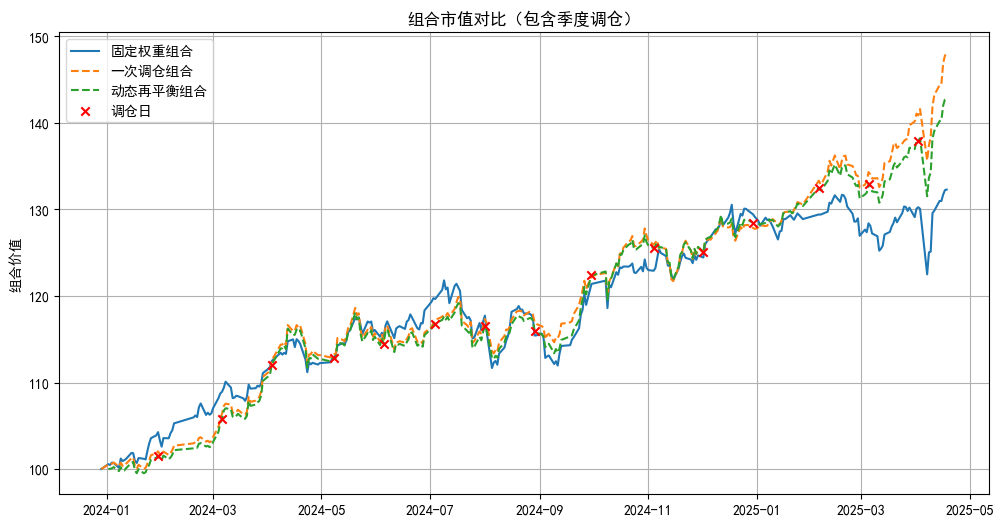

In [19]:
# 进行滚动调整资产权重后
# ----------------------------------------
# 9. 动态再平衡组合优化
# ----------------------------------------

def dynamic_rebalancing(prices, initial_weights, rebalance_freq=30, window=500, start_date='2024-01-01', end_date='2025-04-18', cov_method=cov_method):
    """
    定期再平衡组合优化
    - rebalance_freq: 再平衡周期（交易日数）
    - window: 协方差矩阵计算窗口
    """
    # 协方差估计函数
    cov={
        'equal': equal_weight_cov,
        'ewma': ewma_cov,
        'garch': garch_cov,
        'dcc': garch_dcc_cov
    }

    # 获取时间区间
    all_dates = prices.loc[start_date:end_date].index
    target_dates = prices.loc[start_date:end_date].index
    
    # 初始化持仓
    current_weights = initial_weights.copy()
    port_values = pd.Series(index=target_dates, dtype=float)
    
    # 记录每次调仓时的权重
    rebalance_log = []
    
    # 初始组合价值
    port_values.iloc[0] = 100  # 初始价值为100万元
    
    for i in range(1, len(target_dates)):
        current_date = target_dates[i]
        prev_date = target_dates[i-1]
        
        # 计算价格变化比例
        price_ratio = prices.loc[current_date] / prices.loc[prev_date]
        
        # 更新组合价值（未再平衡时自然变化）
        port_values.iloc[i] = port_values.iloc[i-1] * (current_weights.dot(price_ratio))
        
        # 检查是否需要再平衡
        if i % rebalance_freq == 0: # 隔rebalance_freq天再平衡一次
            # 获取当前实际权重（考虑价格变动后的自然权重）
            current_natural_weights = (current_weights * price_ratio) / np.sum(current_weights * price_ratio)
            # 计算当前各资产的实际价值
            # value_weights = port_values.iloc[i] * current_natural_weights
            
            # 获取历史数据计算协方差
            idx = prices.index.get_loc(current_date)
            hist_prices = prices.iloc[idx-window:idx+1]
            
            # 计算收益协方差矩阵
            cov_mat = cov[cov_method](hist_prices.pct_change().dropna())
            
            # 优化新权重（以当前自然权重为初始值）
            optimized_weights = risk_parity_weights(cov_mat, init_weights=current_natural_weights, portfolio_value=port_values.iloc[i],
                                                    pre_date=prev_date, predic_date=current_date)
            print("优化时间：",current_date)
            
            # 更新持仓权重
            current_weights = optimized_weights
            # print("优化权重：",optimized_weights.tolist())
            rebalance_log.append({
                'date': current_date,
                'weights': optimized_weights.copy().tolist()
            })
            # print(optimized_weights)
            
            # 调整后价值保持不变（仅调整权重比例）
            # 实际交易中需要卖出/买入操作，此处简化为立即切换权重
            # port_values.iloc[i] = port_values.iloc[i]  # 价值不变，仅调整持仓结构
    
    return port_values, pd.DataFrame(rebalance_log)

# 初始权重（等风险贡献组合）
initial_weights = w_rp

# 运行动态再平衡
dynamic_values, rebalance_log = dynamic_rebalancing(
    prices=prices,
    initial_weights=initial_weights,
    rebalance_freq=20,
    window=500
)

cov_str = {
    'equal': '等权协方差',
    'ewma': '指数加权移动平均协方差',
    'garch': '广义 ARCH协方差',
    'dcc': '广义ARCH(DCC)协方差'
}
# ----------------------------------------
# 10. 可视化对比
# ----------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='固定权重组合')
plt.plot(port_val_rp, label='一次调仓组合', linestyle='--')
plt.plot(dynamic_values, label='动态再平衡组合', linestyle='--')
plt.scatter(rebalance_log['date'], dynamic_values.loc[rebalance_log['date']], 
            color='red', zorder=5, label='调仓日', marker='x')
plt.legend()
plt.title(f'{cov_str[cov_method]}组合市值对比')
plt.ylabel('组合价值')
plt.grid(True)
plt.savefig(f'output/{cov_method}_dynamic_rebalancing.svg')
plt.show()
rebalance_log.to_excel(f'output/{cov_method}_dynamic_weights.xlsx', index=False)
# dynamic_values.rename(columns={dynamic_values.columns[1]: 'Values'})
dynamic_values.name = 'Values'
dynamic_values.to_excel(f'output/{cov_method}_dynamic_values.xlsx')
rebalance_log